In [1]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab


In [2]:
import utils

option = "tokenizer"
tokenizer = utils.load(option)       

/home/lab/anaconda3/envs/SRGAN/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import models, dataset, utils
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor
from torch.utils.data import Dataset, DataLoader

loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


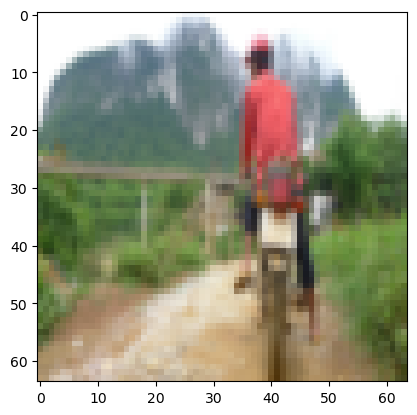

In [4]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

dataDir='..'
dataType='val2017'
COCOdataset = dataset.train_dataset_version2(utils.root, utils.training_dataset_json.format(dataDir,dataType))

train_dataloader = DataLoader(dataset= COCOdataset, batch_size=10, shuffle=True, collate_fn= dataset.collate_fn_version2, num_workers=10)
_, img, anns = COCOdataset[0]
plt.imshow(img.permute(1,2,0).numpy())

In [5]:
class AverageMeter(object):
    """
    computes and stores the average and current value
    """

    def __init__(self, start_val=0, start_count=0, start_avg=0, start_sum=0):
        self.reset()
        self.val = start_val
        self.avg = start_avg
        self.sum = start_sum
        self.count = start_count

    def reset(self):
        """
        Initialize 'value', 'sum', 'count', and 'avg' with 0.
        """
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num):
        """
        Update 'value', 'sum', 'count', and 'avg'.
        """
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count

In [8]:
import models, torch
import time as time
from tqdm import tqdm
import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="skimage.feature.texture")
warnings.filterwarnings("ignore", category=UserWarning, message="The attention mask and the pad token id were not set")
warnings.filterwarnings("ignore", message="The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.")
warnings.filterwarnings("ignore", message="Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.")

os.environ["TOKENIZERS_PARALLELISM"] = "false"
G = models.SRCAP_version1().to('cuda').train()
D = models.Discriminator().to('cuda').train()

learning_rates = {
            'generator': 1e-4,
            'discriminator': 4e-4,
        }

optimizerG = torch.optim.Adam(G.parameters(), lr = learning_rates['generator'])
optimizerD = torch.optim.Adam(D.parameters(), lr = learning_rates['discriminator'])

lr_schedulerr = torch.optim.lr_scheduler.StepLR(optimizer   = optimizerD,
                                            step_size = utils.total_iters,
                                            gamma     = utils.gamma,
                                            )
loop_train = tqdm(
                enumerate(train_dataloader, 1),
                total=len(train_dataloader),
                desc="Train",
                position=0,
                leave=True,
            )

for epoch in range(utils.num_epochs):
    start_time = time.time()    
    G_train_loss = []
    D_train_loss = []
    loss_avg_train = AverageMeter()
    for idx , (img_real, img, anns) in loop_train:
        img_real, img, anns = img_real.to('cuda'), img.to('cuda'), anns.to('cuda')

        #Producing fake image
        optimizerG.zero_grad()
        fake_img, fake_anns = G(img)
        #Optimization
        G_loss = utils.G_loss(fake_anns, anns, fake_img, img_real, D(fake_img))
        G_loss.requires_grad_(True)
        G_loss.backward()
        optimizerG.step()
        
        #Discriminator
        optimizerD.zero_grad()
        fake_img = G.SR(img)
        discriminated_real_images = D(img_real)
        discriminated_fake_images = D(fake_img)
        D_loss = utils.GANLoss('vanilla', 'D', 'S')
        D_loss = D_loss.D_loss(discriminated_fake_images, discriminated_real_images)
        D_loss.requires_grad_(True)
        D_loss.backward()
        optimizerD.step()

        D_train_loss.append(D_loss.item())
        test_psnr = utils.psnr(img_real, fake_img)
        loss_avg_train.update(G_loss.item(), anns.shape[0])
        loop_train.set_description(f"Train - iteration : {epoch}")
        loop_train.set_postfix(
                loss_batch="{:.4f}".format(G_loss.detach().item()),
                avg_train_loss_till_current_batch="{:.4f}".format(loss_avg_train.avg),
                D_loss_batch="{:.4f}".format(D_loss.detach().item()),
                psnr="{:.4f}".format(test_psnr),
                refresh=True,
                
        )       
    print(f'[{epoch + 1}, {idx:5d}] G_loss : {torch.tensor(G_train_loss).mean() : 3f}')

Train - iteration : 0: 100%|██████████| 11829/11829 [9:34:17<00:00,  2.91s/it, D_loss_batch=1.3863, avg_train_loss_till_current_batch=2.3467, loss_batch=2.2328, psnr=25.4134]  

[1, 11829] G_loss :  nan
[2, 11829] G_loss :  nan


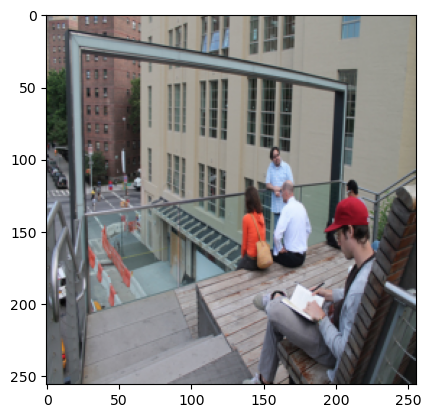

In [9]:
plt.imshow(img_real[2].permute(1,2,0).cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


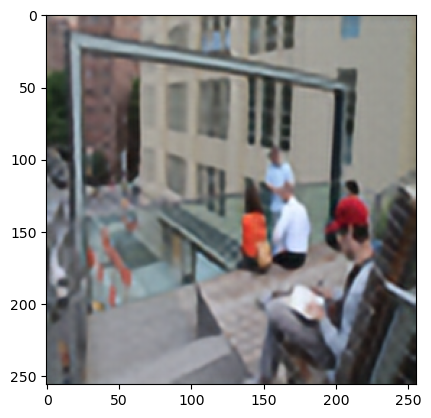

In [10]:
plt.imshow(fake_img[2].permute(1,2,0).cpu().detach().numpy())

In [11]:
print(utils.load("tokenizer").batch_decode(anns[2],  skip_special_tokens=True))

['A', ' group', ' of', ' people', ' that', ' are', ' sitting', ' on', ' benches', '.']


In [12]:
print(utils.load("tokenizer").batch_decode(fake_anns[2],  skip_special_tokens=True))

[' makes', ' particular', ' problem', ' cle', ' early', ' author', 'There', ' former', ' there', ' mechanics']


In [13]:
model_name, folder_path = utils.make_dir()
utils.save_model(folder_path, model_name, G)

Folder 'models/testing/LR=8e-05 Upscaling_factor= 4 d_out_mean=True batch_sizet=10 N_ROI=10 Fine_tuning=True/checkpoints' already exists.


TypeError: cannot unpack non-iterable NoneType object